In [12]:
import glob, os, re, json, pickle
import pandas as pd
from classifier import *
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

%reload_ext autoreload
%autoreload 2

# Human labeled data

In [11]:
df_human = pd.read_json('human_labeled_data.json')
df_human['text'] = df_human['text_data'].str.replace('https[^\s]*\s', '')
df_human['manifestolabel_true'] = df_human['major_label'].str.replace('\d\d\d ','')
# df_human['manifestolabel_true'] = df_human['manifestolabel_true'].replace('ignored','undefined')
df_human = df_human.drop(['text_data','labeled','major_label','selected','taught','labels','users','uncertainty','text_id','predicted_label'],axis=1)
# df_human.to_json('human_labeled_anonymized.json',orient='records')
df_human.sample(n=20)

,text,manifestolabel_true
46,"„Die Digitalisierung der Verwaltung schleift einfach. Keine Verwaltung ist wirklich digital, was auch daran liegt, dass es den Verwaltungen freigestellt wird.“ @AnnaVTreuenfels",infrastructure +
723,"Brütende Rotmilane wegen Windkraft erschossen? - es geht bei Energiewende und Klimaschutz nicht um die Umwelt, sondern um Geld und Macht. Wir brauchen Naturschutz statt linker Ideologie!",environmentalism +
927,"„Das C in #CDU steht nicht für Christenclub"" - @SerapGueler über unsere #Heimat und unsere Partei. „warum falsch mit den Morden in #Hanau umgeht, welche die Fehler der @CDU bei #Migranten gemacht hat und weshalb @ArminLaschet #Kanzler werden sollte“",multiculturalism +
93,Wie ein Post-#Corona-#Konjunkturprogramm den #Klimaschutz mitdenkt: Förderung energetische Gebäudesanierung + klimafreundliches Heizen Senkung #EEG-Umlage #Verkehrswende in Gang setzen Investition in zukunftssichere Industrieanlagen Energiewende europäisch denken,environmentalism +
280,"Waschmaschinen von Männer für Frauen gemacht. Schon mal im Flusensieb rumgepfriemelt, Männers?",ignored
341,Spoiler: Wenn Corona die Menschheit ausrottet ist der #Klimawandel besiegt. Traurig dass ein Virus mehr für den #Klimaschutz tut als die Bundesregierung.,environmentalism +
31,Ich mag die vielen Frauen in diesen Führungspositionen. Spiegelt gerecht den Anteil der Frauen in den sozialen Berufen wider. Perfekt.,social justice +
98,"Wenn du in das Reich Gottes eintreten willst ... Sie müssen zur Gerechtigkeit des Messias zurückkehren ... Und Dies wird erreicht, indem die wahre Errettung Christi Jesus angenommen wird. #HeavenlyFocusedChristian",traditional morality +
830,Ich* bin von Natur aus rebellisch. *putzt Holztisch mit Glasreiniger,ignored
546,In der #Corona-Pandemie haben ohnehin miserable Arbeitsbedingungen in #Schlachthöfe​n schwere Konsequenzen. Gesundheit geht vor Profitinteressen. Deshalb besserer #Arbeitsschutz häufigere Kontrolle der Betriebe Arbeitskräfte über Arbeitnehmerrechte informieren,labour +


In [13]:
df_human['manifestolabel_true'].value_counts()

ignored                   175
environmentalism +        156
political authority +     130
democracy +               112
social justice +          79 
freedom/human rights +    49 
education +               43 
infrastructure +          36 
welfare +                 34 
europe +                  19 
culture +                 17 
anti-growth economy +     16 
agriculture +             12 
free enterprise +         12 
national way of life +    11 
social harmony +          9  
labour +                  9  
law and order +           7  
market regulation +       7  
multiculturalism +        7  
military +                7  
productivity +            7  
traditional morality +    6  
europe -                  5  
multiculturalism -        5  
national way of life -    5  
non economic groups +     4  
traditional morality -    4  
internationalism +        3  
foreign special +         3  
nationalization +         3  
political corruption -    2  
military -                2  
controlled

# Classification performance on tweets

* we want to predict manifesto codes on tweets well
* but we only have few tweets labeled
* we'd like to use as much training data as possible
* but we don't want to degrade manifesto-prediction performance on tweets by adding irrelevant manifesto training data. 

$\rightarrow$ How many manifesto training data should be have in our training set to achieve high tweet classification performance?

$\Rightarrow$ **Crossvalidation with blending in manifesto data**:
* We start with 0 manifesto data and all labeled tweets and add manifesto data
* We evaluate on held-out tweet data 

In [16]:
mixin_manifesto = []

for N in [0, 100, 500, 1000, 5000, 10000]:
    for rep in range(10):
        df_manifesto = get_manifesto_data()
        tweets_train, tweets_test, labels_train,  labels_test = train_test_split(df_human['text'], 
                                                                                 df_human['manifestolabel_true'],
                                                                                 test_size=.2)
        df_manifesto = df_manifesto.sample(n=N)
        train_text = pd.concat([df_manifesto['text'],tweets_train])
        train_labels = pd.concat([df_manifesto['manifestolabel'],labels_train]) 

        enough_samples_per_class = train_labels.value_counts() > 5
        valid = train_labels.isin(enough_samples_per_class[enough_samples_per_class==True].index)

        train_single(train_text[valid], train_labels[valid], 'tweets_and_manifesto')

        df_test = pd.concat([tweets_test,labels_test],axis=1)
        df_test.columns = ['text','manifestolabel_true']
        tw = score_texts(df_test,['tweets_and_manifesto'])
        results_tweets_and_manifesto_df = pd.DataFrame(classification_report(tw['manifestolabel_true'],tw['tweets_and_manifesto'],output_dict=True,zero_division=0)).T
        print(f'N={N}\n')
        print(results_tweets_and_manifesto_df[results_tweets_and_manifesto_df['f1-score']>0])
        mixin_manifesto.append(
        {
            'N': N,
            'rep': rep,
            'f1':results_tweets_and_manifesto_df.loc['weighted avg','f1-score']
        })

mixin_manifesto_df = pd.DataFrame(mixin_manifesto)

Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.1s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=0

                       precision    recall  f1-score     support
culture +              0.750000   0.750000  0.750000  4.000000  
democracy +            0.846154   0.846154  0.846154  26.000000 
education +            0.636364   0.777778  0.700000  9.000000  
environmentalism +     0.846154   0.846154  0.846154  26.000000 
europe +               1.000000   1.000000  1.000000  6.000000  
ignored                0.760000   0.542857  0.633333  35.000000 
infrastructure +       0.500000   0.166667  0.250000  6.000000  
political authority +  0.814815   0.687500  0.745763  32.000000 
social justice +       0.833333   0.833333  0.833333  12.000000 
accuracy               0.551724   0.551724  0.551724  0.551724  
macro avg              0.249529   0.230373  0.235883  203.000000
weighted avg           0.612815   0.551724  0.575523  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.9s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=0

                        precision    recall  f1-score     support
democracy +             0.931034   0.843750  0.885246  32.000000 
education +             0.750000   1.000000  0.857143  6.000000  
environmentalism +      0.818182   0.600000  0.692308  30.000000 
europe +                0.666667   0.666667  0.666667  3.000000  
freedom/human rights +  0.555556   0.500000  0.526316  10.000000 
ignored                 0.600000   0.264706  0.367347  34.000000 
political authority +   0.589744   0.741935  0.657143  31.000000 
social justice +        0.833333   0.909091  0.869565  11.000000 
welfare +               1.000000   0.166667  0.285714  6.000000  
accuracy                0.497537   0.497537  0.497537  0.497537  
macro avg               0.217565   0.183639  0.187337  203.000000
weighted avg            0.592329   0.497537  0.520413  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=0

                       precision    recall  f1-score     support
democracy +            0.869565   0.869565  0.869565  23.000000 
education +            0.750000   0.545455  0.631579  11.000000 
environmentalism +     0.875000   0.700000  0.777778  40.000000 
ignored                0.608696   0.560000  0.583333  25.000000 
infrastructure +       0.666667   0.400000  0.500000  5.000000  
political authority +  0.666667   0.952381  0.784314  21.000000 
social justice +       1.000000   0.583333  0.736842  12.000000 
accuracy               0.477833   0.477833  0.477833  0.477833  
macro avg              0.169894   0.144085  0.152607  203.000000
weighted avg           0.531038   0.477833  0.494850  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=0

                        precision    recall  f1-score    support
culture +               1.000000   0.500000  0.666667  6.00000  
democracy +             0.777778   0.736842  0.756757  19.00000 
education +             1.000000   0.692308  0.818182  13.00000 
environmentalism +      0.805556   0.805556  0.805556  36.00000 
europe +                0.500000   0.500000  0.500000  6.00000  
freedom/human rights +  0.428571   0.375000  0.400000  8.00000  
ignored                 0.500000   0.225806  0.311111  31.00000 
infrastructure +        1.000000   0.400000  0.571429  5.00000  
political authority +   0.586207   0.772727  0.666667  22.00000 
social justice +        0.777778   0.500000  0.608696  14.00000 
welfare +               1.000000   0.166667  0.285714  6.00000  
accuracy                0.467980   0.467980  0.467980  0.46798  
macro avg               0.261747   0.177341  0.199712  203.00000
weighted avg            0.588630   0.467980  0.500586  203.00000
Loading manifesto/ma

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=0

                        precision    recall  f1-score     support
culture +               1.000000   0.500000  0.666667  6.000000  
democracy +             0.888889   0.800000  0.842105  20.000000 
education +             0.700000   0.777778  0.736842  9.000000  
environmentalism +      0.827586   0.750000  0.786885  32.000000 
freedom/human rights +  1.000000   0.384615  0.555556  13.000000 
ignored                 0.600000   0.500000  0.545455  30.000000 
political authority +   0.750000   0.782609  0.765957  23.000000 
social justice +        0.764706   0.866667  0.812500  15.000000 
accuracy                0.497537   0.497537  0.497537  0.497537  
macro avg               0.217706   0.178722  0.190399  203.000000
weighted avg            0.572813   0.497537  0.522386  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=0

                        precision    recall  f1-score     support
culture +               1.000000   0.666667  0.800000  3.000000  
democracy +             0.800000   0.666667  0.727273  24.000000 
education +             0.444444   0.666667  0.533333  6.000000  
environmentalism +      0.694444   0.862069  0.769231  29.000000 
europe +                0.400000   0.666667  0.500000  3.000000  
freedom/human rights +  0.800000   0.266667  0.400000  15.000000 
ignored                 0.933333   0.437500  0.595745  32.000000 
infrastructure +        0.500000   0.166667  0.250000  6.000000  
political authority +   0.534884   0.851852  0.657143  27.000000 
social justice +        0.900000   0.500000  0.642857  18.000000 
welfare +               1.000000   0.166667  0.285714  12.000000 
accuracy                0.502463   0.502463  0.502463  0.502463  
macro avg               0.276107   0.204072  0.212458  203.000000
weighted avg            0.658690   0.502463  0.523000  203.000000
Loadi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


N=0

                        precision    recall  f1-score     support
democracy +             0.875000   0.736842  0.800000  19.000000 
education +             0.428571   0.750000  0.545455  4.000000  
environmentalism +      0.814815   0.666667  0.733333  33.000000 
freedom/human rights +  0.818182   0.900000  0.857143  10.000000 
ignored                 0.739130   0.459459  0.566667  37.000000 
infrastructure +        0.750000   0.375000  0.500000  8.000000  
political authority +   0.571429   0.714286  0.634921  28.000000 
social justice +        0.722222   0.764706  0.742857  17.000000 
welfare +               1.000000   0.250000  0.400000  8.000000  
accuracy                0.507389   0.507389  0.507389  0.507389  
macro avg               0.191981   0.160485  0.165154  203.000000
weighted avg            0.606087   0.507389  0.535597  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=0

                        precision    recall  f1-score     support
culture +               1.000000   0.500000  0.666667  2.000000  
democracy +             0.826087   0.760000  0.791667  25.000000 
education +             0.428571   0.750000  0.545455  4.000000  
environmentalism +      0.852941   0.783784  0.816901  37.000000 
freedom/human rights +  0.444444   0.666667  0.533333  6.000000  
ignored                 0.695652   0.470588  0.561404  34.000000 
infrastructure +        1.000000   0.600000  0.750000  5.000000  
political authority +   0.657143   0.718750  0.686567  32.000000 
social justice +        0.666667   0.571429  0.615385  14.000000 
welfare +               1.000000   0.375000  0.545455  8.000000  
accuracy                0.536946   0.536946  0.536946  0.536946  
macro avg               0.252384   0.206541  0.217094  203.000000
weighted avg            0.618749   0.536946  0.564133  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 c

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=0

                       precision    recall  f1-score     support
culture +              1.000000   0.714286  0.833333  7.000000  
democracy +            0.952381   0.952381  0.952381  21.000000 
education +            0.500000   0.500000  0.500000  10.000000 
environmentalism +     0.812500   0.722222  0.764706  36.000000 
ignored                0.772727   0.425000  0.548387  40.000000 
law and order +        0.333333   1.000000  0.500000  1.000000  
political authority +  0.583333   0.777778  0.666667  18.000000 
social justice +       0.842105   0.727273  0.780488  22.000000 
accuracy               0.512315   0.512315  0.512315  0.512315  
macro avg              0.186980   0.187708  0.178902  203.000000
weighted avg           0.598614   0.512315  0.541719  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=0

                        precision    recall  f1-score     support
culture +               0.833333   1.000000  0.909091  5.000000  
democracy +             0.894737   0.809524  0.850000  21.000000 
education +             0.750000   1.000000  0.857143  9.000000  
environmentalism +      0.714286   0.869565  0.784314  23.000000 
europe +                0.428571   1.000000  0.600000  3.000000  
freedom/human rights +  0.714286   0.625000  0.666667  8.000000  
ignored                 0.937500   0.348837  0.508475  43.000000 
infrastructure +        0.500000   0.166667  0.250000  6.000000  
political authority +   0.540541   0.869565  0.666667  23.000000 
social justice +        0.722222   0.812500  0.764706  16.000000 
welfare +               0.666667   0.285714  0.400000  7.000000  
accuracy                0.541872   0.541872  0.541872  0.541872  
macro avg               0.248456   0.251206  0.234099  203.000000
weighted avg            0.616265   0.541872  0.537021  203.000000
Loadi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=100

                        precision    recall  f1-score     support
agriculture +           0.500000   1.000000  0.666667  2.000000  
culture +               1.000000   0.500000  0.666667  2.000000  
democracy +             0.800000   0.842105  0.820513  19.000000 
environmentalism +      0.904762   0.633333  0.745098  30.000000 
europe +                0.555556   0.833333  0.666667  6.000000  
freedom/human rights +  0.600000   0.272727  0.375000  11.000000 
ignored                 0.684211   0.361111  0.472727  36.000000 
infrastructure +        0.600000   0.333333  0.428571  9.000000  
political authority +   0.617647   0.700000  0.656250  30.000000 
social justice +        0.750000   0.562500  0.642857  16.000000 
accuracy                0.453202   0.453202  0.453202  0.453202  
macro avg               0.241799   0.208222  0.211759  203.000000
weighted avg            0.570627   0.453202  0.490556  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=100

                        precision    recall  f1-score     support
democracy +             0.933333   0.608696  0.736842  23.000000 
education +             0.333333   0.428571  0.375000  7.000000  
environmentalism +      0.896552   0.666667  0.764706  39.000000 
freedom/human rights +  0.500000   0.285714  0.363636  7.000000  
ignored                 0.705882   0.387097  0.500000  31.000000 
law and order +         1.000000   1.000000  1.000000  1.000000  
political authority +   0.583333   0.807692  0.677419  26.000000 
social justice +        0.785714   0.523810  0.628571  21.000000 
welfare +               1.000000   0.250000  0.400000  8.000000  
accuracy                0.453202   0.453202  0.453202  0.453202  
macro avg               0.232350   0.170974  0.187799  203.000000
weighted avg            0.614850   0.453202  0.504701  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=100

                        precision    recall  f1-score     support
culture +               1.000000   0.285714  0.444444  7.000000  
democracy +             0.666667   0.777778  0.717949  18.000000 
education +             0.750000   0.900000  0.818182  10.000000 
environmentalism +      0.736842   0.777778  0.756757  18.000000 
europe +                0.800000   0.800000  0.800000  5.000000  
freedom/human rights +  0.800000   0.444444  0.571429  9.000000  
ignored                 0.666667   0.352941  0.461538  34.000000 
infrastructure +        0.666667   0.285714  0.400000  7.000000  
political authority +   0.583333   0.840000  0.688525  25.000000 
social justice +        0.750000   0.600000  0.666667  15.000000 
accuracy                0.448276   0.448276  0.448276  0.448276  
macro avg               0.218240   0.178364  0.186044  203.000000
weighted avg            0.512955   0.448276  0.456581  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=100

                        precision    recall  f1-score    support
agriculture +           1.000000   1.000000  1.000000  1.00000  
culture +               1.000000   0.666667  0.800000  3.00000  
democracy +             0.842105   0.842105  0.842105  19.00000 
education +             0.555556   0.555556  0.555556  9.00000  
environmentalism +      0.848485   0.800000  0.823529  35.00000 
europe +                0.666667   1.000000  0.800000  4.00000  
freedom/human rights +  0.500000   0.555556  0.526316  9.00000  
ignored                 0.750000   0.357143  0.483871  42.00000 
political authority +   0.750000   0.777778  0.763636  27.00000 
social justice +        0.846154   0.687500  0.758621  16.00000 
accuracy                0.532020   0.532020  0.532020  0.53202  
macro avg               0.277106   0.258654  0.262630  203.00000
weighted avg            0.626365   0.532020  0.562754  203.00000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=100

                        precision    recall  f1-score     support
culture +               1.000000   1.000000  1.000000  4.000000  
democracy +             0.884615   0.793103  0.836364  29.000000 
education +             0.583333   0.700000  0.636364  10.000000 
environmentalism +      0.787879   0.787879  0.787879  33.000000 
europe +                0.666667   1.000000  0.800000  2.000000  
freedom/human rights +  0.333333   0.142857  0.200000  7.000000  
ignored                 0.736842   0.318182  0.444444  44.000000 
political authority +   0.650000   0.590909  0.619048  22.000000 
social justice +        0.916667   0.647059  0.758621  17.000000 
accuracy                0.497537   0.497537  0.497537  0.497537  
macro avg               0.234262   0.213571  0.217240  203.000000
weighted avg            0.627873   0.497537  0.540342  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=100

                        precision    recall  f1-score     support
culture +               1.000000   0.400000  0.571429  5.000000  
democracy +             0.840000   0.777778  0.807692  27.000000 
education +             0.800000   0.800000  0.800000  10.000000 
environmentalism +      0.866667   0.722222  0.787879  36.000000 
freedom/human rights +  0.833333   0.333333  0.476190  15.000000 
ignored                 0.933333   0.518519  0.666667  27.000000 
political authority +   0.680000   0.680000  0.680000  25.000000 
social justice +        0.818182   0.500000  0.620690  18.000000 
accuracy                0.502463   0.502463  0.502463  0.502463  
macro avg               0.241840   0.168995  0.193234  203.000000
weighted avg            0.671464   0.502463  0.563270  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=100

                        precision    recall  f1-score     support
democracy +             1.000000   0.772727  0.871795  22.000000 
education +             0.400000   1.000000  0.571429  4.000000  
environmentalism +      0.648649   0.800000  0.716418  30.000000 
europe +                0.600000   0.600000  0.600000  5.000000  
freedom/human rights +  0.600000   0.375000  0.461538  8.000000  
ignored                 0.722222   0.371429  0.490566  35.000000 
infrastructure +        1.000000   0.111111  0.200000  9.000000  
law and order +         1.000000   0.500000  0.666667  2.000000  
political authority +   0.631579   0.800000  0.705882  30.000000 
social justice +        0.666667   0.315789  0.428571  19.000000 
accuracy                0.472906   0.472906  0.472906  0.472906  
macro avg               0.242304   0.188202  0.190429  203.000000
weighted avg            0.584982   0.472906  0.489027  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: Runti

N=100

                        precision    recall  f1-score     support
culture +               1.000000   1.000000  1.000000  1.000000  
democracy +             0.894737   0.739130  0.809524  23.000000 
education +             0.555556   0.714286  0.625000  7.000000  
environmentalism +      0.750000   0.750000  0.750000  24.000000 
europe +                1.000000   0.200000  0.333333  5.000000  
freedom/human rights +  0.428571   0.250000  0.315789  12.000000 
ignored                 0.833333   0.348837  0.491803  43.000000 
infrastructure +        1.000000   0.285714  0.444444  7.000000  
political authority +   0.575000   0.741935  0.647887  31.000000 
social justice +        0.625000   0.625000  0.625000  8.000000  
welfare +               0.500000   0.142857  0.222222  7.000000  
accuracy                0.448276   0.448276  0.448276  0.448276  
macro avg               0.291507   0.207063  0.223750  203.000000
weighted avg            0.604774   0.448276  0.484477  203.000000
Loa

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=100

                       precision    recall  f1-score     support
culture +              0.750000   1.000000  0.857143  3.000000  
democracy +            0.941176   0.695652  0.800000  23.000000 
education +            0.833333   1.000000  0.909091  5.000000  
environmentalism +     0.843750   0.818182  0.830769  33.000000 
ignored                0.900000   0.391304  0.545455  46.000000 
political authority +  0.541667   0.520000  0.530612  25.000000 
social justice +       0.600000   0.500000  0.545455  12.000000 
accuracy               0.433498   0.433498  0.433498  0.433498  
macro avg              0.200368   0.182413  0.185871  203.000000
weighted avg           0.581523   0.433498  0.481941  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=100

                        precision    recall  f1-score     support
culture +               0.500000   0.333333  0.400000  3.000000  
democracy +             0.894737   0.653846  0.755556  26.000000 
education +             0.857143   0.750000  0.800000  8.000000  
environmentalism +      0.823529   0.823529  0.823529  34.000000 
europe +                1.000000   1.000000  1.000000  2.000000  
freedom/human rights +  0.666667   0.545455  0.600000  11.000000 
ignored                 0.900000   0.500000  0.642857  36.000000 
infrastructure +        0.500000   0.285714  0.363636  7.000000  
political authority +   0.593750   0.826087  0.690909  23.000000 
social justice +        0.923077   0.666667  0.774194  18.000000 
accuracy                0.546798   0.546798  0.546798  0.546798  
macro avg               0.255297   0.212821  0.228356  203.000000
weighted avg            0.665642   0.546798  0.587976  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.6s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=500

                        precision    recall  f1-score     support
culture +               0.250000   1.000000  0.400000  2.000000  
democracy +             0.900000   0.500000  0.642857  18.000000 
education +             0.666667   0.800000  0.727273  10.000000 
environmentalism +      0.695652   0.516129  0.592593  31.000000 
freedom/human rights +  0.625000   0.833333  0.714286  6.000000  
ignored                 0.769231   0.270270  0.400000  37.000000 
infrastructure +        0.500000   0.200000  0.285714  5.000000  
political authority +   0.518519   0.608696  0.560000  23.000000 
social justice +        0.857143   0.300000  0.444444  20.000000 
accuracy                0.349754   0.349754  0.349754  0.349754  
macro avg               0.180694   0.157138  0.148974  203.000000
weighted avg            0.535528   0.349754  0.395555  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.6s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]

N=500

                        precision    recall  f1-score     support
agriculture +           1.000000   0.500000  0.666667  2.000000  
culture +               0.666667   0.666667  0.666667  6.000000  
democracy +             0.937500   0.652174  0.769231  23.000000 
education +             0.777778   0.500000  0.608696  14.000000 
environmentalism +      0.821429   0.718750  0.766667  32.000000 
freedom/human rights +  0.750000   0.300000  0.428571  10.000000 
ignored                 1.000000   0.259259  0.411765  27.000000 
infrastructure +        1.000000   0.500000  0.666667  6.000000  
law and order +         1.000000   1.000000  1.000000  1.000000  
political authority +   0.600000   0.692308  0.642857  26.000000 
social justice +        0.769231   0.454545  0.571429  22.000000 
welfare +               1.000000   0.142857  0.250000  7.000000  
accuracy                0.458128   0.458128  0.458128  0.458128  
macro avg               0.355952   0.220226  0.256869  203.000000
wei

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.6s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: Runti

N=500

                        precision    recall  f1-score     support
culture +               1.000000   0.500000  0.666667  4.000000  
democracy +             0.833333   0.800000  0.816327  25.000000 
education +             0.666667   0.750000  0.705882  8.000000  
environmentalism +      0.806452   0.806452  0.806452  31.000000 
europe +                0.666667   0.666667  0.666667  6.000000  
freedom/human rights +  0.666667   0.444444  0.533333  9.000000  
ignored                 0.800000   0.222222  0.347826  36.000000 
infrastructure +        0.714286   0.555556  0.625000  9.000000  
political authority +   0.666667   0.620690  0.642857  29.000000 
social justice +        0.900000   0.600000  0.720000  15.000000 
accuracy                0.497537   0.497537  0.497537  0.497537  
macro avg               0.275741   0.213073  0.233250  203.000000
weighted avg            0.656298   0.497537  0.542421  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=500

                        precision    recall  f1-score     support
culture +               1.000000   0.750000  0.857143  4.000000  
democracy +             0.937500   0.714286  0.810811  21.000000 
education +             0.444444   0.571429  0.500000  7.000000  
environmentalism +      0.857143   0.731707  0.789474  41.000000 
europe +                0.500000   1.000000  0.666667  2.000000  
freedom/human rights +  0.545455   0.600000  0.571429  10.000000 
ignored                 0.833333   0.312500  0.454545  32.000000 
infrastructure +        1.000000   0.333333  0.500000  12.000000 
military +              1.000000   1.000000  1.000000  1.000000  
political authority +   0.478261   0.578947  0.523810  19.000000 
social justice +        0.846154   0.578947  0.687500  19.000000 
welfare +               1.000000   0.142857  0.250000  7.000000  
accuracy                0.482759   0.482759  0.482759  0.482759  
macro avg               0.314743   0.243800  0.253713  203.000000
wei

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=500

                        precision    recall  f1-score    support
culture +               1.000000   0.833333  0.909091  6.00000  
democracy +             0.782609   0.782609  0.782609  23.00000 
education +             0.714286   1.000000  0.833333  5.00000  
environmentalism +      0.760000   0.612903  0.678571  31.00000 
europe +                0.800000   0.666667  0.727273  6.00000  
freedom/human rights +  1.000000   0.400000  0.571429  10.00000 
ignored                 0.733333   0.314286  0.440000  35.00000 
infrastructure +        0.833333   0.625000  0.714286  8.00000  
political authority +   0.545455   0.571429  0.558140  21.00000 
social justice +        0.777778   0.437500  0.560000  16.00000 
accuracy                0.443350   0.443350  0.443350  0.44335  
macro avg               0.294326   0.231249  0.250916  203.00000
weighted avg            0.601792   0.443350  0.495222  203.00000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: Runti

N=500

                        precision    recall  f1-score     support
culture +               0.750000   1.000000  0.857143  3.000000  
democracy +             0.857143   0.545455  0.666667  22.000000 
education +             0.615385   0.888889  0.727273  9.000000  
environmentalism +      0.888889   0.600000  0.716418  40.000000 
europe +                0.666667   1.000000  0.800000  2.000000  
freedom/human rights +  0.600000   0.333333  0.428571  9.000000  
ignored                 0.720000   0.545455  0.620690  33.000000 
infrastructure +        0.750000   0.333333  0.461538  9.000000  
political authority +   0.633333   0.633333  0.633333  30.000000 
social justice +        0.727273   0.533333  0.615385  15.000000 
welfare +               0.666667   0.500000  0.571429  4.000000  
accuracy                0.502463   0.502463  0.502463  0.502463  
macro avg               0.262512   0.230438  0.236615  203.000000
weighted avg            0.650346   0.502463  0.556899  203.000000
Loa

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: Runti

N=500

                        precision    recall  f1-score     support
culture +               0.500000   0.500000  0.500000  2.000000  
democracy +             0.909091   0.476190  0.625000  21.000000 
education +             0.600000   0.857143  0.705882  7.000000  
environmentalism +      0.760000   0.760000  0.760000  25.000000 
europe +                0.750000   0.500000  0.600000  6.000000  
freedom/human rights +  0.125000   0.166667  0.142857  6.000000  
ignored                 0.909091   0.250000  0.392157  40.000000 
infrastructure +        0.666667   0.285714  0.400000  7.000000  
political authority +   0.740741   0.689655  0.714286  29.000000 
social justice +        0.733333   0.647059  0.687500  17.000000 
welfare +               1.000000   0.333333  0.500000  9.000000  
accuracy                0.423645   0.423645  0.423645  0.423645  
macro avg               0.248191   0.176315  0.194441  203.000000
weighted avg            0.652805   0.423645  0.482322  203.000000
Loa

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=500

                        precision    recall  f1-score     support
agriculture +           1.000000   0.250000  0.400000  4.000000  
culture +               1.000000   0.800000  0.888889  5.000000  
democracy +             0.625000   0.909091  0.740741  11.000000 
education +             0.500000   0.555556  0.526316  9.000000  
environmentalism +      0.700000   0.700000  0.700000  30.000000 
freedom/human rights +  0.714286   0.555556  0.625000  9.000000  
ignored                 0.900000   0.257143  0.400000  35.000000 
market regulation +     0.500000   1.000000  0.666667  1.000000  
political authority +   0.800000   0.645161  0.714286  31.000000 
social justice +        0.928571   0.650000  0.764706  20.000000 
accuracy                0.438424   0.438424  0.438424  0.438424  
macro avg               0.255595   0.210750  0.214220  203.000000
weighted avg            0.606773   0.438424  0.481074  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=500

                        precision    recall  f1-score     support
culture +               1.000000   1.000000  1.000000  2.000000  
democracy +             0.933333   0.608696  0.736842  23.000000 
education +             0.777778   0.583333  0.666667  12.000000 
environmentalism +      0.714286   0.689655  0.701754  29.000000 
europe +                0.666667   0.666667  0.666667  3.000000  
freedom/human rights +  0.500000   0.600000  0.545455  10.000000 
ignored                 0.666667   0.242424  0.355556  33.000000 
political authority +   0.538462   0.736842  0.622222  19.000000 
social justice +        0.769231   0.555556  0.645161  18.000000 
welfare +               0.500000   0.111111  0.181818  9.000000  
accuracy                0.413793   0.413793  0.413793  0.413793  
macro avg               0.207836   0.170420  0.180063  203.000000
weighted avg            0.547247   0.413793  0.451023  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=500

                        precision    recall  f1-score     support
culture +               1.000000   0.500000  0.666667  2.000000  
democracy +             0.900000   0.782609  0.837209  23.000000 
education +             0.500000   0.250000  0.333333  12.000000 
environmentalism +      0.774194   0.705882  0.738462  34.000000 
europe +                0.750000   0.750000  0.750000  4.000000  
freedom/human rights +  1.000000   0.454545  0.625000  11.000000 
ignored                 0.611111   0.379310  0.468085  29.000000 
infrastructure +        1.000000   0.571429  0.727273  7.000000  
political authority +   0.608696   0.538462  0.571429  26.000000 
social justice +        0.666667   0.444444  0.533333  18.000000 
accuracy                0.448276   0.448276  0.448276  0.448276  
macro avg               0.251957   0.173441  0.201638  203.000000
weighted avg            0.598871   0.448276  0.505884  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.6s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: Runti

N=1000

                        precision    recall  f1-score    support
culture +               1.000000   1.000000  1.000000  2.00000  
democracy +             1.000000   0.727273  0.842105  22.00000 
education +             0.500000   0.300000  0.375000  10.00000 
environmentalism +      0.714286   0.483871  0.576923  31.00000 
europe +                0.500000   0.666667  0.571429  3.00000  
freedom/human rights +  1.000000   0.250000  0.400000  8.00000  
ignored                 1.000000   0.250000  0.400000  32.00000 
infrastructure +        1.000000   0.285714  0.444444  7.00000  
political authority +   0.666667   0.666667  0.666667  21.00000 
social justice +        1.000000   0.421053  0.592593  19.00000 
accuracy                0.354680   0.354680  0.354680  0.35468  
macro avg               0.246499   0.148566  0.172622  203.00000
weighted avg            0.653413   0.354680  0.434707  203.00000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.7s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: Runti

N=1000

                        precision    recall  f1-score     support
agriculture +           0.500000   0.500000  0.500000  2.000000  
culture +               1.000000   0.333333  0.500000  3.000000  
democracy +             0.954545   0.807692  0.875000  26.000000 
education +             0.636364   0.777778  0.700000  9.000000  
environmentalism +      0.913043   0.617647  0.736842  34.000000 
europe +                0.666667   1.000000  0.800000  2.000000  
freedom/human rights +  0.888889   0.571429  0.695652  14.000000 
ignored                 1.000000   0.272727  0.428571  33.000000 
infrastructure +        1.000000   0.250000  0.400000  8.000000  
military +              1.000000   1.000000  1.000000  1.000000  
political authority +   0.750000   0.461538  0.571429  26.000000 
social justice +        0.857143   0.461538  0.600000  13.000000 
accuracy                0.448276   0.448276  0.448276  0.448276  
macro avg               0.327956   0.227538  0.251855  203.000000
we

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.7s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=1000

                        precision    recall  f1-score     support
culture +               1.000000   0.333333  0.500000  3.000000  
democracy +             0.750000   0.714286  0.731707  21.000000 
education +             0.555556   0.555556  0.555556  9.000000  
environmentalism +      0.809524   0.566667  0.666667  30.000000 
europe +                1.000000   0.500000  0.666667  2.000000  
freedom/human rights +  0.800000   0.400000  0.533333  10.000000 
ignored                 1.000000   0.209302  0.346154  43.000000 
political authority +   0.600000   0.461538  0.521739  26.000000 
social justice +        0.714286   0.454545  0.555556  11.000000 
accuracy                0.339901   0.339901  0.339901  0.339901  
macro avg               0.225918   0.131101  0.158668  203.000000
weighted avg            0.613265   0.339901  0.409327  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.6s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=1000

                        precision    recall  f1-score     support
culture +               1.000000   0.333333  0.500000  3.000000  
democracy +             0.857143   0.631579  0.727273  19.000000 
education +             0.857143   0.666667  0.750000  9.000000  
environmentalism +      0.846154   0.611111  0.709677  36.000000 
europe +                0.666667   0.800000  0.727273  5.000000  
freedom/human rights +  0.571429   0.333333  0.421053  12.000000 
ignored                 0.750000   0.162162  0.266667  37.000000 
infrastructure +        1.000000   0.333333  0.500000  6.000000  
military +              1.000000   1.000000  1.000000  1.000000  
political authority +   0.681818   0.681818  0.681818  22.000000 
social justice +        0.777778   0.388889  0.518519  18.000000 
accuracy                0.394089   0.394089  0.394089  0.394089  
macro avg               0.300271   0.198074  0.226743  203.000000
weighted avg            0.647301   0.394089  0.465545  203.000000
Lo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.6s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: Runti

N=1000

                        precision    recall  f1-score     support
culture +               1.000000   1.000000  1.000000  3.000000  
democracy +             1.000000   0.666667  0.800000  18.000000 
education +             0.500000   0.800000  0.615385  10.000000 
environmentalism +      0.800000   0.571429  0.666667  35.000000 
europe +                0.750000   0.750000  0.750000  4.000000  
freedom/human rights +  0.500000   0.333333  0.400000  6.000000  
ignored                 0.750000   0.243243  0.367347  37.000000 
infrastructure +        0.500000   0.200000  0.285714  5.000000  
political authority +   0.611111   0.523810  0.564103  21.000000 
social justice +        0.750000   0.461538  0.571429  13.000000 
accuracy                0.369458   0.369458  0.369458  0.369458  
macro avg               0.217003   0.168182  0.182444  203.000000
weighted avg            0.555829   0.369458  0.426514  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.6s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: Runti

N=1000

                        precision    recall  f1-score     support
culture +               1.000000   0.500000  0.666667  2.000000  
democracy +             0.869565   0.714286  0.784314  28.000000 
education +             0.750000   0.500000  0.600000  6.000000  
environmentalism +      0.900000   0.545455  0.679245  33.000000 
freedom/human rights +  0.500000   0.428571  0.461538  7.000000  
ignored                 0.909091   0.222222  0.357143  45.000000 
political authority +   0.687500   0.550000  0.611111  20.000000 
social justice +        0.666667   0.285714  0.400000  14.000000 
accuracy                0.344828   0.344828  0.344828  0.344828  
macro avg               0.209427   0.124875  0.152001  203.000000
weighted avg            0.630740   0.344828  0.425781  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.6s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: Runti

N=1000

                        precision    recall  f1-score     support
culture +               1.000000   0.750000  0.857143  4.000000  
democracy +             0.941176   0.842105  0.888889  19.000000 
education +             0.250000   0.111111  0.153846  9.000000  
environmentalism +      0.812500   0.433333  0.565217  30.000000 
europe +                0.833333   0.833333  0.833333  6.000000  
freedom/human rights +  1.000000   0.333333  0.500000  6.000000  
ignored                 0.666667   0.250000  0.363636  40.000000 
infrastructure +        0.800000   0.500000  0.615385  8.000000  
political authority +   0.666667   0.518519  0.583333  27.000000 
social justice +        0.909091   0.588235  0.714286  17.000000 
accuracy                0.384236   0.384236  0.384236  0.384236  
macro avg               0.254175   0.166451  0.195970  203.000000
weighted avg            0.620830   0.384236  0.463153  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.7s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


N=1000

                        precision    recall  f1-score     support
culture +               0.750000   1.000000  0.857143  3.000000  
democracy +             0.947368   0.857143  0.900000  21.000000 
education +             0.666667   0.500000  0.571429  12.000000 
environmentalism +      0.774194   0.666667  0.716418  36.000000 
europe +                0.750000   0.600000  0.666667  5.000000  
freedom/human rights +  0.727273   0.666667  0.695652  12.000000 
ignored                 0.857143   0.193548  0.315789  31.000000 
infrastructure +        0.500000   0.142857  0.222222  7.000000  
political authority +   0.750000   0.480000  0.585366  25.000000 
social justice +        0.785714   0.647059  0.709677  17.000000 
welfare +               1.000000   0.125000  0.222222  8.000000  
accuracy                0.458128   0.458128  0.458128  0.458128  
macro avg               0.265886   0.183717  0.201956  203.000000
weighted avg            0.692963   0.458128  0.520307  203.000000
Lo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.7s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=1000

                       precision    recall  f1-score     support
culture +              1.000000   0.500000  0.666667  4.000000  
democracy +            0.866667   0.565217  0.684211  23.000000 
education +            0.833333   0.714286  0.769231  7.000000  
environmentalism +     0.772727   0.653846  0.708333  26.000000 
europe +               0.800000   0.800000  0.800000  5.000000  
ignored                0.888889   0.275862  0.421053  29.000000 
infrastructure +       0.600000   0.300000  0.400000  10.000000 
political authority +  0.576923   0.517241  0.545455  29.000000 
social justice +       0.750000   0.428571  0.545455  14.000000 
accuracy               0.359606   0.359606  0.359606  0.359606  
macro avg              0.244432   0.163966  0.191048  203.000000
weighted avg           0.555991   0.359606  0.423004  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.8s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=1000

                        precision    recall  f1-score     support
agriculture +           0.333333   0.500000  0.400000  2.000000  
culture +               1.000000   0.750000  0.857143  4.000000  
democracy +             0.882353   0.714286  0.789474  21.000000 
education +             0.714286   0.555556  0.625000  9.000000  
environmentalism +      0.777778   0.840000  0.807692  25.000000 
europe +                0.750000   0.750000  0.750000  4.000000  
freedom/human rights +  0.666667   0.400000  0.500000  10.000000 
ignored                 0.750000   0.166667  0.272727  36.000000 
infrastructure +        1.000000   0.125000  0.222222  8.000000  
political authority +   0.760000   0.655172  0.703704  29.000000 
social justice +        0.909091   0.588235  0.714286  17.000000 
accuracy                0.433498   0.433498  0.433498  0.433498  
macro avg               0.275597   0.194997  0.214266  203.000000
weighted avg            0.646455   0.433498  0.486557  203.000000
Lo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.2s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


N=5000

                       precision    recall  f1-score     support
democracy +            0.777778   0.350000  0.482759  20.000000 
environmentalism +     0.545455   0.176471  0.266667  34.000000 
europe +               1.000000   0.600000  0.750000  5.000000  
infrastructure +       1.000000   0.200000  0.333333  5.000000  
military +             1.000000   1.000000  1.000000  1.000000  
political authority +  0.636364   0.280000  0.388889  25.000000 
social justice +       1.000000   0.333333  0.500000  15.000000 
accuracy               0.147783   0.147783  0.147783  0.147783  
macro avg              0.175282   0.086465  0.109460  203.000000
weighted avg           0.374434   0.147783  0.208674  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    3.5s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.6s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=5000

                       precision    recall  f1-score     support
culture +              1.000000   0.250000  0.400000  4.000000  
democracy +            1.000000   0.380952  0.551724  21.000000 
education +            1.000000   0.125000  0.222222  8.000000  
environmentalism +     0.600000   0.171429  0.266667  35.000000 
infrastructure +       0.500000   0.142857  0.222222  7.000000  
political authority +  0.777778   0.269231  0.400000  26.000000 
social justice +       1.000000   0.380952  0.551724  21.000000 
accuracy               0.157635   0.157635  0.157635  0.157635  
macro avg              0.209921   0.061444  0.093377  203.000000
weighted avg           0.486316   0.157635  0.235660  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.5s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=5000

                        precision    recall  f1-score     support
culture +               0.666667   0.400000  0.500000  5.000000  
democracy +             1.000000   0.444444  0.615385  18.000000 
environmentalism +      0.900000   0.281250  0.428571  32.000000 
europe +                0.333333   1.000000  0.500000  1.000000  
freedom/human rights +  0.714286   0.357143  0.476190  14.000000 
ignored                 1.000000   0.071429  0.133333  28.000000 
political authority +   0.375000   0.142857  0.206897  21.000000 
social justice +        1.000000   0.277778  0.434783  18.000000 
accuracy                0.172414   0.172414  0.172414  0.172414  
macro avg               0.181494   0.090149  0.099853  203.000000
weighted avg            0.563259   0.172414  0.248089  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.9s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=5000

                        precision    recall  f1-score     support
democracy +             1.000000   0.538462  0.700000  26.000000 
education +             0.625000   0.416667  0.500000  12.000000 
environmentalism +      0.666667   0.270270  0.384615  37.000000 
europe +                0.500000   0.200000  0.285714  5.000000  
freedom/human rights +  1.000000   0.125000  0.222222  8.000000  
political authority +   0.833333   0.217391  0.344828  23.000000 
social justice +        1.000000   0.071429  0.133333  14.000000 
accuracy                0.182266   0.182266  0.182266  0.182266  
macro avg               0.187500   0.061307  0.085690  203.000000
weighted avg            0.501642   0.182266  0.253373  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.8s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=5000

                        precision    recall  f1-score    support
culture +               0.500000   0.333333  0.400000  3.00000  
democracy +             0.894737   0.708333  0.790698  24.00000 
environmentalism +      0.818182   0.281250  0.418605  32.00000 
europe +                0.500000   0.200000  0.285714  5.00000  
freedom/human rights +  1.000000   0.125000  0.222222  8.00000  
labour +                1.000000   1.000000  1.000000  1.00000  
military +              1.000000   0.333333  0.500000  3.00000  
political authority +   0.600000   0.136364  0.222222  22.00000 
social justice +        1.000000   0.111111  0.200000  18.00000 
accuracy                0.177340   0.177340  0.177340  0.17734  
macro avg               0.215086   0.094962  0.118808  203.00000
weighted avg            0.467268   0.177340  0.235307  203.00000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


N=5000

                       precision    recall  f1-score     support
culture +              1.000000   0.250000  0.400000  4.000000  
democracy +            0.785714   0.423077  0.550000  26.000000 
environmentalism +     1.000000   0.200000  0.333333  35.000000 
europe +               1.000000   0.500000  0.666667  2.000000  
ignored                1.000000   0.030303  0.058824  33.000000 
political authority +  0.500000   0.107143  0.176471  28.000000 
social justice +       0.666667   0.095238  0.166667  21.000000 
accuracy               0.128079   0.128079  0.128079  0.128079  
macro avg              0.212585   0.057349  0.083999  203.000000
weighted avg           0.603096   0.128079  0.193509  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.4s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=5000

                        precision    recall  f1-score     support
culture +               1.000000   0.333333  0.500000  3.000000  
democracy +             1.000000   0.368421  0.538462  19.000000 
education +             0.666667   0.285714  0.400000  7.000000  
environmentalism +      0.777778   0.259259  0.388889  27.000000 
europe +                0.500000   0.666667  0.571429  3.000000  
freedom/human rights +  0.666667   0.250000  0.363636  8.000000  
infrastructure +        0.666667   0.285714  0.400000  7.000000  
law and order +         1.000000   0.500000  0.666667  2.000000  
political authority +   0.700000   0.205882  0.318182  34.000000 
social justice +        1.000000   0.153846  0.266667  13.000000 
accuracy                0.162562   0.162562  0.162562  0.162562  
macro avg               0.249306   0.103401  0.137935  203.000000
weighted avg            0.482594   0.162562  0.236809  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.7s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


N=5000

                       precision    recall  f1-score     support
culture +              1.000000   1.000000  1.000000  2.000000  
democracy +            0.857143   0.521739  0.648649  23.000000 
education +            0.166667   0.142857  0.153846  7.000000  
environmentalism +     0.571429   0.307692  0.400000  26.000000 
europe +               0.500000   0.200000  0.285714  5.000000  
infrastructure +       0.666667   0.200000  0.307692  10.000000 
political authority +  0.714286   0.192308  0.303030  26.000000 
social justice +       1.000000   0.200000  0.333333  20.000000 
accuracy               0.172414   0.172414  0.172414  0.172414  
macro avg              0.176651   0.089181  0.110718  203.000000
weighted avg           0.421065   0.172414  0.233728  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.7s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=5000

                        precision    recall  f1-score     support
culture +               1.000000   0.200000  0.333333  5.000000  
democracy +             0.846154   0.478261  0.611111  23.000000 
environmentalism +      0.900000   0.272727  0.418605  33.000000 
europe +                0.500000   0.200000  0.285714  5.000000  
freedom/human rights +  0.500000   0.153846  0.235294  13.000000 
political authority +   0.600000   0.111111  0.187500  27.000000 
social justice +        1.000000   0.166667  0.285714  18.000000 
accuracy                0.147783   0.147783  0.147783  0.147783  
macro avg               0.178205   0.052754  0.078576  203.000000
weighted avg            0.479613   0.147783  0.217876  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.2s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


N=5000

                        precision    recall  f1-score     support
democracy +             1.000000   0.428571  0.600000  21.000000 
environmentalism +      0.875000   0.280000  0.424242  25.000000 
freedom/human rights +  0.666667   0.307692  0.421053  13.000000 
political authority +   0.600000   0.120000  0.200000  25.000000 
social justice +        0.666667   0.333333  0.444444  12.000000 
accuracy                0.133005   0.133005  0.133005  0.133005  
macro avg               0.122849   0.047406  0.067411  203.000000
weighted avg            0.367200   0.133005  0.192183  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    3.4s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.6s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=10000

                       precision    recall  f1-score     support
agriculture +          1.000000   0.250000  0.400000  4.000000  
democracy +            0.857143   0.315789  0.461538  19.000000 
education +            0.666667   0.222222  0.333333  9.000000  
environmentalism +     0.833333   0.142857  0.243902  35.000000 
political authority +  1.000000   0.166667  0.285714  18.000000 
social justice +       0.666667   0.105263  0.181818  19.000000 
accuracy               0.093596   0.093596  0.093596  0.093596  
macro avg              0.167460   0.040093  0.063544  203.000000
weighted avg           0.424232   0.093596  0.150262  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.0s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


N=10000

                       precision    recall  f1-score     support
culture +              1.000000   0.333333  0.500000  3.000000  
democracy +            1.000000   0.136364  0.240000  22.000000 
education +            1.000000   0.066667  0.125000  15.000000 
environmentalism +     1.000000   0.103448  0.187500  29.000000 
europe +               0.500000   0.166667  0.250000  6.000000  
political authority +  0.333333   0.050000  0.086957  20.000000 
social justice +       1.000000   0.071429  0.133333  14.000000 
accuracy               0.054187   0.054187  0.054187  0.054187  
macro avg              0.194444   0.030930  0.050760  203.000000
weighted avg           0.456486   0.054187  0.094573  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.5s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


N=10000

                        precision    recall  f1-score     support
democracy +             1.000000   0.318182  0.482759  22.000000 
education +             1.000000   0.090909  0.166667  11.000000 
freedom/human rights +  0.666667   0.222222  0.333333  9.000000  
political authority +   1.000000   0.066667  0.125000  30.000000 
social justice +        1.000000   0.083333  0.153846  12.000000 
accuracy                0.064039   0.064039  0.064039  0.064039  
macro avg               0.155556   0.026044  0.042053  203.000000
weighted avg            0.399015   0.064039  0.103695  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.8s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=10000

                        precision    recall  f1-score     support
culture +               1.000000   0.166667  0.285714  6.000000  
democracy +             0.888889   0.421053  0.571429  19.000000 
education +             0.500000   0.100000  0.166667  10.000000 
environmentalism +      0.600000   0.115385  0.193548  26.000000 
freedom/human rights +  0.500000   0.166667  0.250000  12.000000 
infrastructure +        1.000000   0.100000  0.181818  10.000000 
law and order +         1.000000   0.333333  0.500000  3.000000  
political authority +   0.833333   0.217391  0.344828  23.000000 
social justice +        1.000000   0.105263  0.190476  19.000000 
accuracy                0.118227   0.118227  0.118227  0.118227  
macro avg               0.228819   0.053930  0.083890  203.000000
weighted avg            0.495840   0.118227  0.182949  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.4s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.3s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=10000

                       precision    recall  f1-score     support
culture +              1.000000   0.500000  0.666667  2.000000  
democracy +            1.000000   0.315789  0.480000  19.000000 
education +            0.500000   0.166667  0.250000  6.000000  
environmentalism +     0.500000   0.024390  0.046512  41.000000 
political authority +  0.600000   0.115385  0.193548  26.000000 
social justice +       0.666667   0.133333  0.222222  15.000000 
accuracy               0.068966   0.068966  0.068966  0.068966  
macro avg              0.137634   0.040502  0.059966  203.000000
weighted avg           0.345320   0.068966  0.109487  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.6s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=10000

                        precision    recall  f1-score   support
democracy +             1.000000   0.458333  0.628571  24.0000 
environmentalism +      0.666667   0.166667  0.266667  36.0000 
freedom/human rights +  0.666667   0.181818  0.285714  11.0000 
political authority +   0.500000   0.133333  0.210526  30.0000 
accuracy                0.113300   0.113300  0.113300  0.1133  
macro avg               0.088542   0.029380  0.043484  203.0000
weighted avg            0.346470   0.113300  0.168199  203.0000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.4s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

N=10000

                       precision    recall  f1-score     support
democracy +            1.000000   0.352941  0.521739  17.000000 
education +            0.750000   0.250000  0.375000  12.000000 
environmentalism +     0.900000   0.214286  0.346154  42.000000 
military +             1.000000   1.000000  1.000000  1.000000  
political authority +  1.000000   0.181818  0.307692  22.000000 
social justice +       0.750000   0.157895  0.260870  19.000000 
accuracy               0.128079   0.128079  0.128079  0.128079  
macro avg              0.200000   0.079887  0.104128  203.000000
weighted avg           0.497783   0.128079  0.200166  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.4s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


N=10000

                       precision    recall  f1-score     support
culture +              1.000000   0.333333  0.500000  3.000000  
democracy +            0.857143   0.352941  0.500000  17.000000 
education +            1.000000   0.100000  0.181818  10.000000 
environmentalism +     0.750000   0.103448  0.181818  29.000000 
europe +               0.500000   0.500000  0.500000  2.000000  
political authority +  0.857143   0.181818  0.300000  33.000000 
social justice +       1.000000   0.125000  0.222222  16.000000 
accuracy               0.098522   0.098522  0.098522  0.098522  
macro avg              0.175420   0.049898  0.070172  203.000000
weighted avg           0.466045   0.098522  0.155401  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.7s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


N=10000

                       precision    recall  f1-score     support
culture +              1.000000   1.000000  1.000000  3.000000  
democracy +            0.875000   0.241379  0.378378  29.000000 
environmentalism +     1.000000   0.068966  0.129032  29.000000 
military +             1.000000   0.250000  0.400000  4.000000  
political authority +  0.500000   0.047619  0.086957  21.000000 
social justice +       1.000000   0.153846  0.266667  13.000000 
accuracy               0.078818   0.078818  0.078818  0.078818  
macro avg              0.179167   0.058727  0.075368  203.000000
weighted avg           0.418103   0.078818  0.121220  203.000000
Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.9s finished
/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


N=10000

                        precision    recall  f1-score     support
democracy +             1.000000   0.300000  0.461538  20.000000 
education +             1.000000   0.250000  0.400000  8.000000  
environmentalism +      1.000000   0.051282  0.097561  39.000000 
freedom/human rights +  0.666667   0.166667  0.266667  12.000000 
infrastructure +        1.000000   0.125000  0.222222  8.000000  
political authority +   0.666667   0.066667  0.121212  30.000000 
social justice +        1.000000   0.052632  0.100000  19.000000 
accuracy                0.078818   0.078818  0.078818  0.078818  
macro avg               0.211111   0.033742  0.055640  203.000000
weighted avg            0.600985   0.078818  0.131772  203.000000


/Users/felix/anaconda3/envs/pdds_1920/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Results

More than 500 manifesto samples lead to decreased classification performance on held-out tweets 

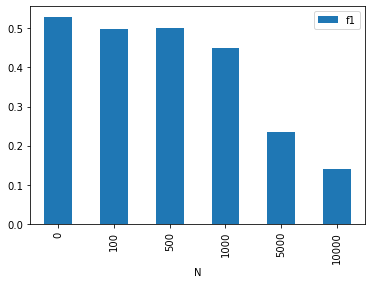

In [18]:
mixin_manifesto_df.groupby('N').agg({'f1':np.median}).plot.bar()